In [46]:
using JLD2
using Plots
using Statistics
using LinearAlgebra
using Printf
using OrderedCollections 


In [47]:

const data_loc = joinpath(@__DIR__, "mach_prec_data.jld2")

const N_vals = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34]
const σ_vals = [0.0, 0.001, 0.002, 0.005, 0.01]




5-element Vector{Float64}:
 0.0
 0.001
 0.002
 0.005
 0.01

In [48]:
"""
generate_results_data(N_vals, σ_vals, data_loc)

Reads raw Schmidt coefficients from the file.
Calculates:
  1. Deviation Index (k): Index where clean coefs drop below sigma.
  2. Truncation Error: Sum of squared noisy coefs from k onwards.
Returns a list of dictionaries.
"""
function generate_results_data(N_vals, σ_vals, data_loc)
    results = []
    
    if !isfile(data_loc)
        println("Error: Data file not found at '$data_loc'")
        return results
    end

    jldopen(data_loc, "r") do file
        for N in N_vals
            # 1. Load the "Clean" Baseline (σ=0) for this N
            clean_path = "N=$(N)/sigma=0.0"
            if !haskey(file, clean_path)
                println("Warning: No baseline (σ=0) found for N=$N")
                continue
            end
            
            raw_clean = file[clean_path]["schmidt_coefs"][1]
            # Handle potential JLD2 storage types
            clean_coefs = raw_clean isa Vector ? raw_clean : raw_clean.storage.data
            
            # 2. Iterate through Noise levels
            for σ in σ_vals
                if σ == 0 continue end # Skip baseline comparison with itself
                
                group_path = "N=$(N)/sigma=$(σ)"
                if haskey(file, group_path)
                    raw_noisy = file[group_path]["schmidt_coefs"][1]
                    noisy_coefs = raw_noisy isa Vector ? raw_noisy : raw_noisy.storage.data
                    
                    # --- CALCULATE DEVIATION INDEX (k) ---
                    # Find first index where clean coefficient < σ
                    # If clean spectrum is shorter than index, or never drops, handle safely
                    k = findfirst(x -> x < σ, clean_coefs)
                    
                    if isnothing(k)
                        k = length(clean_coefs) # Fallback if never drops below
                    end
                    
                    # --- CALCULATE TRUNCATION ERROR ---
                    # Sum of squared noisy coefficients from k to end
                    # (Ensure k is within bounds of noisy_coefs)
                    if k <= length(noisy_coefs)
                        tail = noisy_coefs[k:end] .^ 2
                        trunc_err = sum(tail)
                    else
                        trunc_err = 0.0
                    end
                    
                    # Store derived data
                    push!(results, Dict(
                        "N" => N,
                        "σ" => σ,
                        "truncation_err" => trunc_err, # Calculated metric
                        "dev_idx" => k                 # Calculated metric
                    ))
                end
            end
        end
    end
    return results
end

# Generate the results variable now
println("Calculating metrics from raw data...")
results = generate_results_data(N_vals, σ_vals, data_loc)
println("Calculated $(length(results)) data points.")

Calculating metrics from raw data...
Calculated 68 data points.


┌ Warning: type NDTensors.Dense{Float64,Vector{Float64}} does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\Ethan\.julia\packages\JLD2\hbsZG\src\data\reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Tensor{Float64,1,JLD2.ReconstructedMutable{Symbol("Dense{Float64,Vector{Float64}}"), (:data,), Tuple{Any}},Tuple{Int64}} does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\Ethan\.julia\packages\JLD2\hbsZG\src\data\reconstructing_datatypes.jl:588


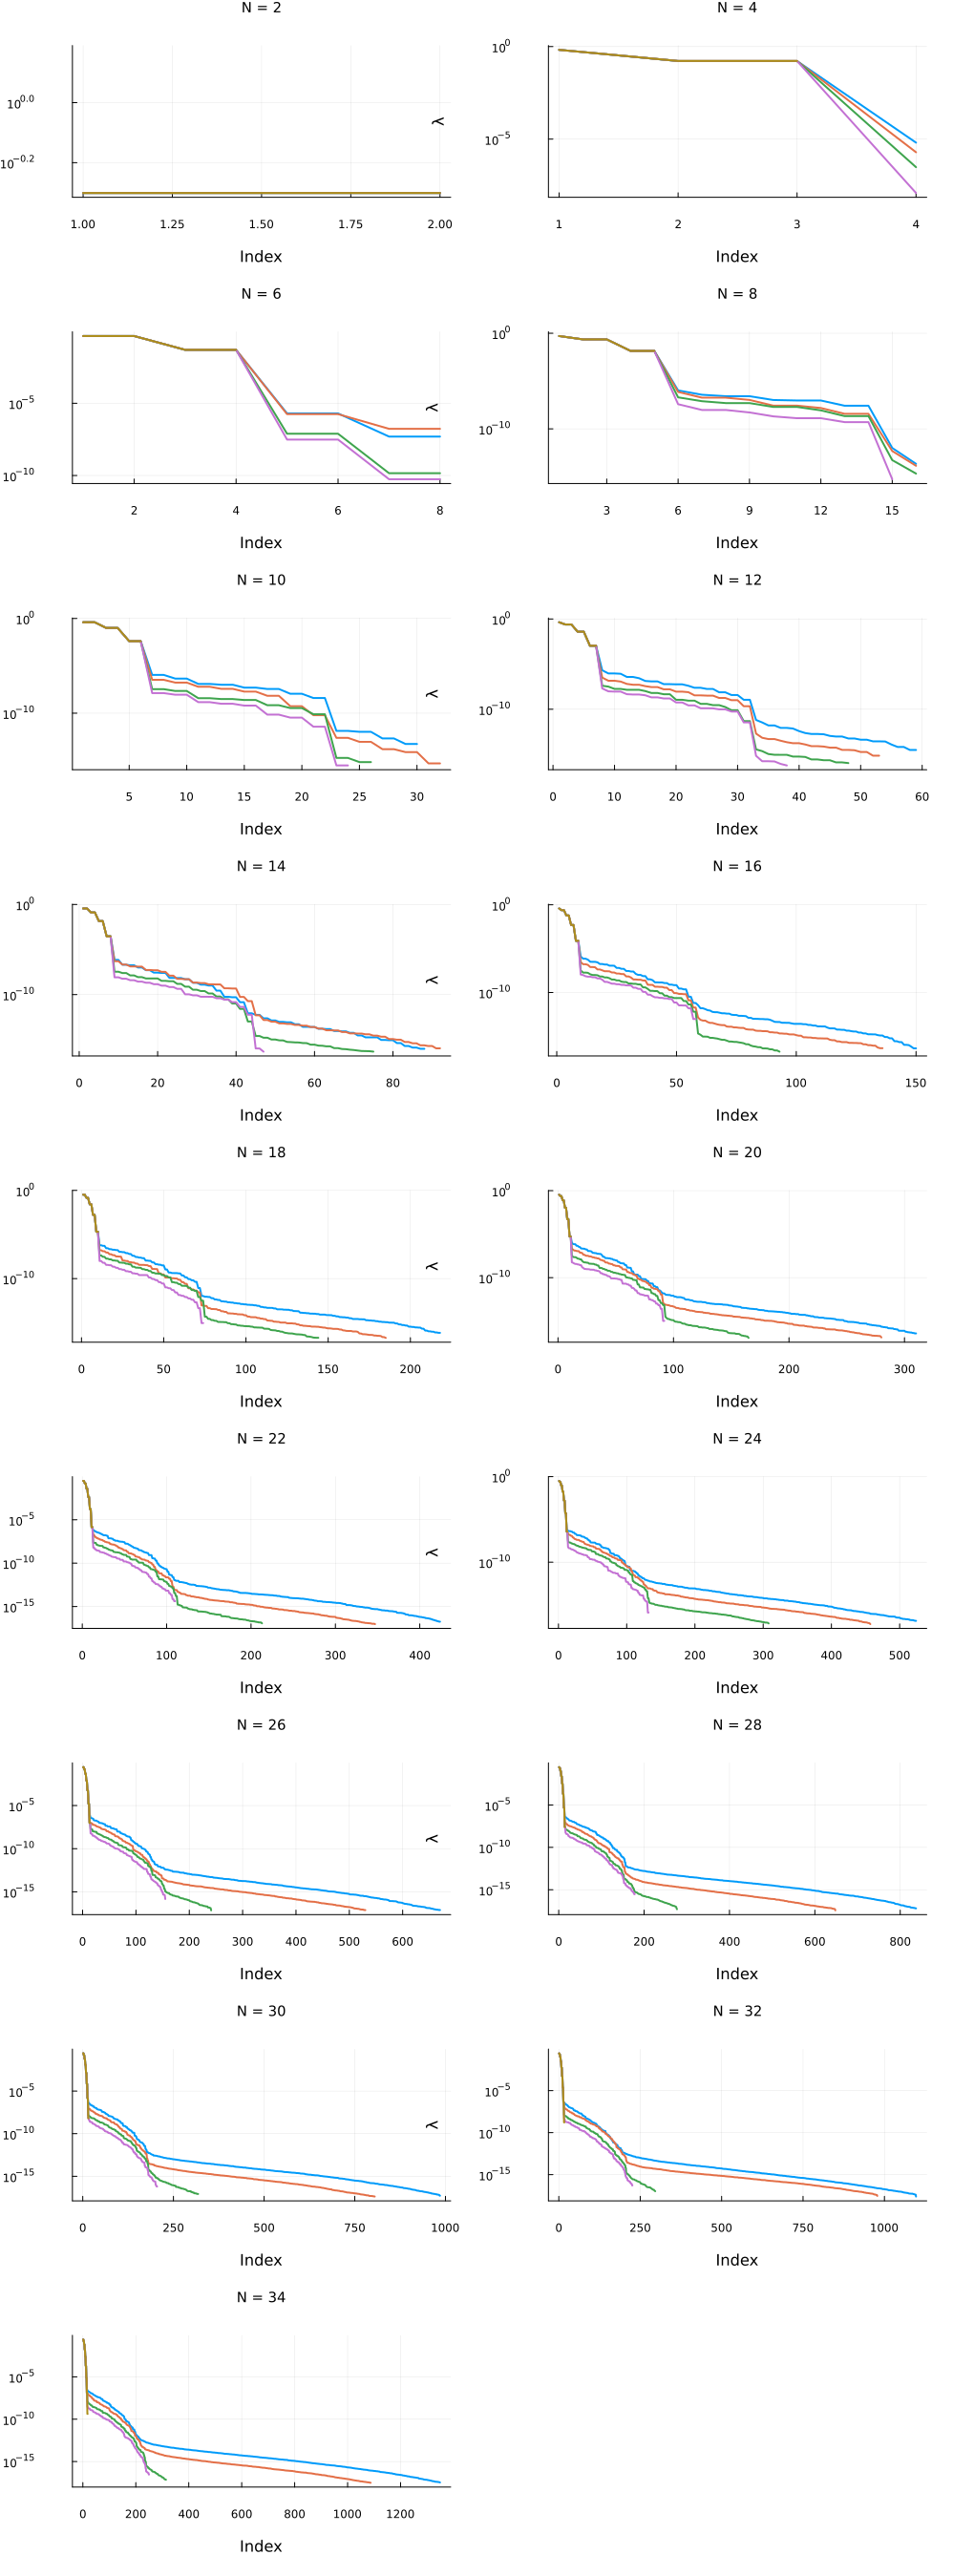

┌ Warning: type NDTensors.Dense{Float64,Vector{Float64}} does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\Ethan\.julia\packages\JLD2\hbsZG\src\data\reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Tensor{Float64,1,JLD2.ReconstructedMutable{Symbol("Dense{Float64,Vector{Float64}}"), (:data,), Tuple{Any}},Tuple{Int64}} does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\Ethan\.julia\packages\JLD2\hbsZG\src\data\reconstructing_datatypes.jl:588


In [49]:


"""
SCHMIDT COEFFICIENT TAIL COMPARISON
   Visualizes the singular value spectrum for all N.
"""
function plot_schmidt_coefficient_tail_comparison(N_vals, σ_vals, data_loc)
    gr()
    plot_list = []
    sigma_iterator = reverse(σ_vals) # Constant Z-order

    jldopen(data_loc, "r") do file
        for N in N_vals
            subplot = plot(
                title = "N = $N", xlabel = "Index", ylabel = "λ",
                yscale = :log10, legend = false, titlefontsize=10
            )
            
            for σ in sigma_iterator
                group_path = "N=$(N)/sigma=$(σ)"
                if haskey(file, group_path)
                    raw = file[group_path]["schmidt_coefs"][1]
                    run_coefs = raw isa Vector ? raw : raw.storage.data
                    
                    spectrum = run_coefs .^ 2
                    spectrum ./= sum(spectrum) # Normalize
                    sorted_spec = sort(spectrum, rev=true)
                    
                    plot!(subplot, 1:length(sorted_spec), sorted_spec, label="σ=$σ", lw=2)
                end
            end
            push!(plot_list, subplot)
        end
    end
    
    # Calculate layout dynamically
    n_rows = cld(length(plot_list), 2)
    final = plot(plot_list..., layout=(n_rows, 2), size=(1000, 300*n_rows), margin=5Plots.mm)
    return final
end


# 1. Schmidt Tail Behavior
p1 = plot_schmidt_coefficient_tail_comparison(N_vals, σ_vals, data_loc)
display(p1)


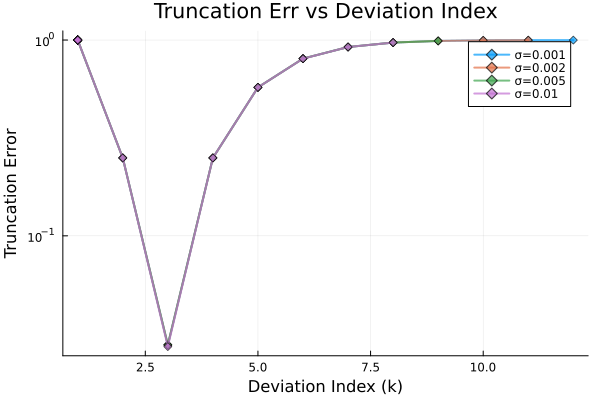

In [50]:

"""
TRUNCATION ERROR VS DEVIATION INDEX
   Shows the power law relationship between where noise starts and the resulting error.
   Uses the 'results' variable.
"""
function plot_deviated_index(results)
    if isempty(results) return end
    unique_sigmas = sort(unique([d["σ"] for d in results]))
    
    p = plot(
        title = "Truncation Err vs Deviation Index",
        xlabel = "Deviation Index (k)", ylabel = "Truncation Error",
        legend = :topright, yscale = :log10
    )
    
    for σ in unique_sigmas
        sigma_data = filter(d -> d["σ"] == σ, results)
        sort!(sigma_data, by = d -> d["dev_idx"]) # Sort x-axis for lines
        
        x_vals = [d["dev_idx"] for d in sigma_data]
        y_vals = [d["truncation_err"] for d in sigma_data] .^ 2
        
        plot!(p, x_vals, y_vals, label="σ=$σ", marker=:diamond, lw=2, alpha=0.7)
    end
    return p
end



# 2. Deviation Index Analysis (Uses 'results' variable)
p2 = plot_deviated_index(results)
display(p2)


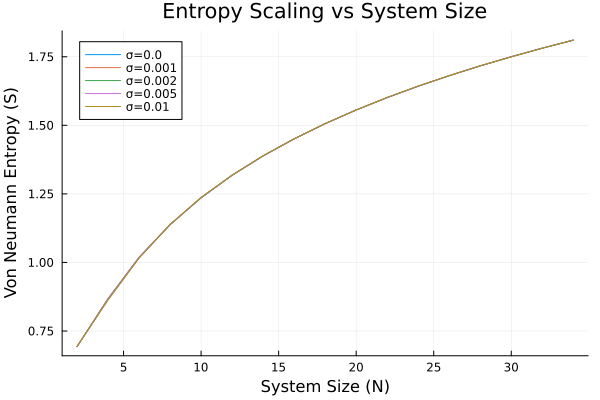

┌ Warning: type NDTensors.Dense{Float64,Vector{Float64}} does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\Ethan\.julia\packages\JLD2\hbsZG\src\data\reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Tensor{Float64,1,JLD2.ReconstructedMutable{Symbol("Dense{Float64,Vector{Float64}}"), (:data,), Tuple{Any}},Tuple{Int64}} does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\Ethan\.julia\packages\JLD2\hbsZG\src\data\reconstructing_datatypes.jl:588


In [51]:


"""
ENTROPY SCALING
   Calculates Von Neumann Entropy on the fly to check for Area/Volume law.
"""
function plot_entropy_scaling(N_vals, σ_vals, data_loc)
    p = plot(
        title = "Entropy Scaling vs System Size",
        xlabel = "System Size (N)", ylabel = "Von Neumann Entropy (S)",
        legend = :topleft, marker = :circle, lw=2
    )

    jldopen(data_loc, "r") do file
        for σ in σ_vals
            x_N, y_S = [], []
            for N in N_vals
                group_path = "N=$(N)/sigma=$(σ)"
                if haskey(file, group_path)
                    raw = file[group_path]["schmidt_coefs"][1]
                    coefs = raw isa Vector ? raw : raw.storage.data
                    
                    spec = coefs .^ 2
                    spec ./= sum(spec)
                    spec = filter(x -> x > 1e-20, spec)
                    S = -sum(spec .* log.(spec))
                    
                    push!(x_N, N); push!(y_S, S)
                end
            end
            if !isempty(x_N)
                perm = sortperm(x_N)
                plot!(p, x_N[perm], y_S[perm], label="σ=$σ")
            end
        end
    end
    return p
end






# 3. Entropy Scaling
p3 = plot_entropy_scaling(N_vals, σ_vals, data_loc)
display(p3)





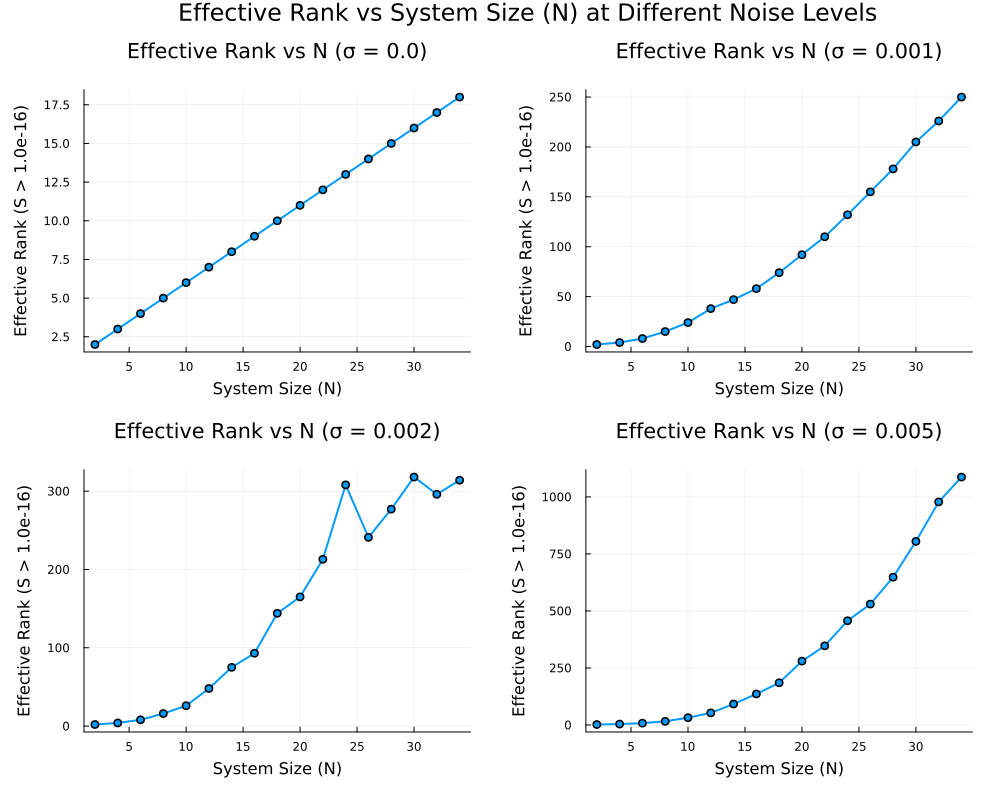

┌ Warning: type NDTensors.Dense{Float64,Vector{Float64}} does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\Ethan\.julia\packages\JLD2\hbsZG\src\data\reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Tensor{Float64,1,JLD2.ReconstructedMutable{Symbol("Dense{Float64,Vector{Float64}}"), (:data,), Tuple{Any}},Tuple{Int64}} does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\Ethan\.julia\packages\JLD2\hbsZG\src\data\reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Dense{Float64,Vector{Float64}} does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\Ethan\.julia\packages\JLD2\hbsZG\src\data\reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Tensor{Float64,1,JLD2.ReconstructedMutable{Symbol("Dense{Float64,Vector{Float64}}"), (:data,), Tuple{Any}},Tuple{Int64}} does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\Ethan\.julia\packages\JLD2\hbsZG\src\data\reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Dense{Float64,Vector{F

In [52]:
"""
plot_effective_rank_vs_N(N_vals, target_sigma, data_loc; epsilon=1e-14)

Plots the Effective Rank (count of singular values > epsilon) against System Size N
for a single fixed noise level (target_sigma).

Args:
  target_sigma: The specific noise value to analyze (e.g., 1e-16).
  epsilon: Threshold for counting a singular value as "significant".
"""
function plot_effective_rank_vs_N(N_vals, target_sigma, data_loc; epsilon=1e-14)
    # Initialise arrays to hold the data for plotting
    x_N = Int[]
    y_rank = Int[]
    

    jldopen(data_loc, "r") do file
        for N in N_vals
            group_key = "N=$(N)"
            
            # Check if N group exists
            if !haskey(file, group_key)
                println("  Warning: Group $group_key not found.")
                continue 
            end
            
            
            found_sigma_key = nothing
            keys_in_group = keys(file[group_key])
            
            for key in keys_in_group
                if startswith(key, "sigma=")
                    # Extract number string (e.g., "0.001")
                    val_str = replace(key, "sigma=" => "")
                    try
                        val = parse(Float64, val_str)
                        # Check numerical equality with tolerance
                        if isapprox(val, target_sigma, atol=1e-20, rtol=1e-5)
                            found_sigma_key = key
                            break
                        end
                    catch
                        continue # Skip unparseable keys
                    end
                end
            end

            if !isnothing(found_sigma_key)
                # Load the coefficients
                raw = file[group_key][found_sigma_key]["schmidt_coefs"][1]
                coefs = raw isa Vector ? raw : raw.storage.data
                
                # Calculate Rank
                rank_val = count(x -> x > epsilon, coefs)
                
                push!(x_N, N)
                push!(y_rank, rank_val)
                
                # println("  N=$N: Rank=$rank_val")
            else
                println("  Warning: No data found for σ=$target_sigma in N=$N group")
            end
        end
    end

    if isempty(x_N)
        println("Error: No matching data found for σ=$target_sigma.")
        return plot(title="No Data")
    end

    # Sort by N to ensure the line connects in order
    perm = sortperm(x_N)
    x_sorted = x_N[perm]
    y_sorted = y_rank[perm]

    p = plot(
        x_sorted, 
        y_sorted,
        title = "Effective Rank vs N (σ = $target_sigma)",
        xlabel = "System Size (N)",
        ylabel = "Effective Rank (S > $epsilon)",
        marker = :circle,
        linewidth = 2,
        legend = false,
        grid = true
    )
    
    return p
end

p1 = plot_effective_rank_vs_N(N_vals, 0.0, data_loc, epsilon = 1e-16)
p2 = plot_effective_rank_vs_N(N_vals, 0.001, data_loc, epsilon = 1e-16)
p3 = plot_effective_rank_vs_N(N_vals, 0.002, data_loc, epsilon = 1e-16)
p4 = plot_effective_rank_vs_N(N_vals, 0.005, data_loc, epsilon = 1e-16)

gridplot = plot(
    p1, p2, p3, p4, 
    layout = (2, 2), 
    size = (1000, 800), 
    plot_title = "Effective Rank vs System Size (N) at Different Noise Levels",
    margin = 5Plots.mm
)

display(gridplot)
# savefig(final_grid, "effective_rank_grid.png")




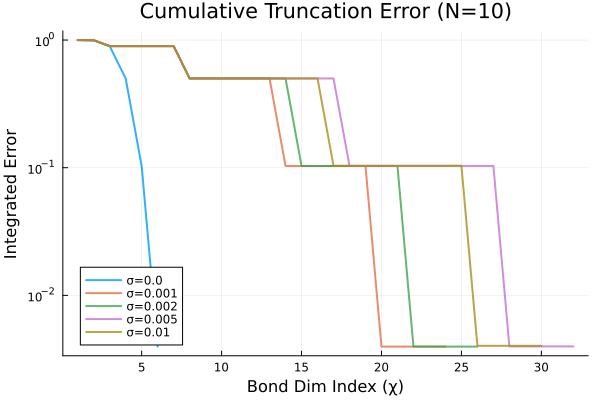

┌ Warning: type NDTensors.Dense{Float64,Vector{Float64}} does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\Ethan\.julia\packages\JLD2\hbsZG\src\data\reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Tensor{Float64,1,JLD2.ReconstructedMutable{Symbol("Dense{Float64,Vector{Float64}}"), (:data,), Tuple{Any}},Tuple{Int64}} does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\Ethan\.julia\packages\JLD2\hbsZG\src\data\reconstructing_datatypes.jl:588


In [53]:

"""
CUMULATIVE ERROR PROFILE
   Shows the integrated tail weight for a specific system size.
"""
function plot_cumulative_error_profile(N_target, σ_vals, data_loc)
    p = plot(
        title = "Cumulative Truncation Error (N=$N_target)",
        xlabel = "Bond Dim Index (χ)", ylabel = "Integrated Error",
        yscale = :log10, legend = :bottomleft
    )

    jldopen(data_loc, "r") do file
        for σ in σ_vals
            group_path = "N=$(N_target)/sigma=$(σ)"
            if haskey(file, group_path)
                raw = file[group_path]["schmidt_coefs"][1]
                coefs = raw isa Vector ? raw : raw.storage.data
                
                spec = coefs .^ 2
                spec ./= sum(spec)
                cum_err = reverse(cumsum(reverse(spec)))
                
                plot!(p, 1:length(cum_err), cum_err, label="σ=$σ", lw=2, alpha=0.8)
            end
        end
    end
    return p
end








# 5. Cumulative Error (for N=10)
p5 = plot_cumulative_error_profile(10, σ_vals, data_loc)
display(p5)







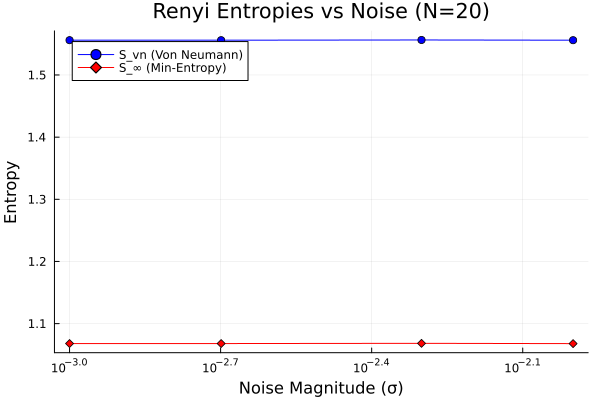

Successfully plotted 4 points for N=20


┌ Warning: type NDTensors.Dense{Float64,Vector{Float64}} does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\Ethan\.julia\packages\JLD2\hbsZG\src\data\reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Tensor{Float64,1,JLD2.ReconstructedMutable{Symbol("Dense{Float64,Vector{Float64}}"), (:data,), Tuple{Any}},Tuple{Int64}} does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\Ethan\.julia\packages\JLD2\hbsZG\src\data\reconstructing_datatypes.jl:588


In [54]:
function plot_renyi_comparison(N_target, σ_vals, data_loc)
    # Create the plot object
    p = plot(
        title = "Renyi Entropies vs Noise (N=$N_target)",
        xlabel = "Noise Magnitude (σ)", 
        ylabel = "Entropy",
        xscale = :log10, 
        legend = :topleft, 
        lw = 2,
        grid = true
    )

    jldopen(data_loc, "r") do file
        # 1. Access the specific System Size group
        group_key = "N=$(N_target)"
        
        if !haskey(file, group_key)
            println("Error: Group $group_key not found in file.")
            return p
        end

        # Arrays to store the data for plotting
        x_sig = Float64[]
        y_vn = Float64[]  # Von Neumann
        y_min = Float64[] # Min-Entropy
        
        # 2. Iterate through ALL keys in this group to find sigmas
        # This avoids the "string matching" bug (1e-16 vs 1.0e-16)
        available_keys = keys(file[group_key])

        for key in available_keys
            if startswith(key, "sigma=")
                # Parse the sigma value from the filename string
                val_str = replace(key, "sigma=" => "")
                
                try
                    current_sigma = parse(Float64, val_str)
                    
                    # Skip sigma=0 (cannot plot on log scale)
                    if current_sigma == 0 continue end

                    # 3. Check if this sigma is in our requested list
                    # We use isapprox to handle floating point tolerances
                    if any(s -> isapprox(s, current_sigma, atol=1e-20, rtol=1e-5), σ_vals)
                        
                        # Load the data
                        raw = file[group_key][key]["schmidt_coefs"][1]
                        # Handle potential storage types (JLD2 quirk)
                        coefs = raw isa Vector ? raw : raw.storage.data
                        
                        # --- CALCULATION ---
                        # Normalize the spectrum (probabilities)
                        P = coefs .^ 2
                        total_prob = sum(P)
                        if total_prob > 0
                            P ./= total_prob
                        end
                        
                        # Von Neumann Entropy: S = -Σ p ln(p)
                        # Add 1e-20 to avoid log(0)
                        S_vn = -sum(P .* log.(P .+ 1e-20)) 
                        
                        # Min-Entropy: S = -ln(max(p))
                        S_min = -log(maximum(P))
                        
                        # Store data
                        push!(x_sig, current_sigma)
                        push!(y_vn, S_vn)
                        push!(y_min, S_min)
                    end
                catch e
                    # Skip keys that fail to parse
                end
            end
        end

        # 4. Sort and Plot
        if !isempty(x_sig)
            # Sort by sigma so the line connects correctly
            perm = sortperm(x_sig)
            
            plot!(p, x_sig[perm], y_vn[perm], 
                  label="S_vn (Von Neumann)", 
                  marker=:circle, 
                  color=:blue)
            
            plot!(p, x_sig[perm], y_min[perm], 
                  label="S_∞ (Min-Entropy)", 
                  marker=:diamond, 
                  color=:red)
            
            println("Successfully plotted $(length(x_sig)) points for N=$N_target")
        else
            println("Warning: No matching sigma data found for N=$N_target")
        end
    end
    
    return p
end

# --- RUN THE CORRECTED PLOT ---
# Uses the N_vals, σ_vals, and data_loc defined in your script
p6 = plot_renyi_comparison(20, σ_vals, data_loc)
display(p6)


=== N=20 Analysis ===
Ideal Bond Dimension (from σ=0): χ = 11


┌ Warning: type NDTensors.Dense{Float64,Vector{Float64}} does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\Ethan\.julia\packages\JLD2\hbsZG\src\data\reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Tensor{Float64,1,JLD2.ReconstructedMutable{Symbol("Dense{Float64,Vector{Float64}}"), (:data,), Tuple{Any}},Tuple{Int64}} does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\Ethan\.julia\packages\JLD2\hbsZG\src\data\reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Dense{Float64,Vector{Float64}} does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\Ethan\.julia\packages\JLD2\hbsZG\src\data\reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Tensor{Float64,1,JLD2.ReconstructedMutable{Symbol("Dense{Float64,Vector{Float64}}"), (:data,), Tuple{Any}},Tuple{Int64}} does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\Ethan\.julia\packages\JLD2\hbsZG\src\data\reconstructing_datatypes.jl:588


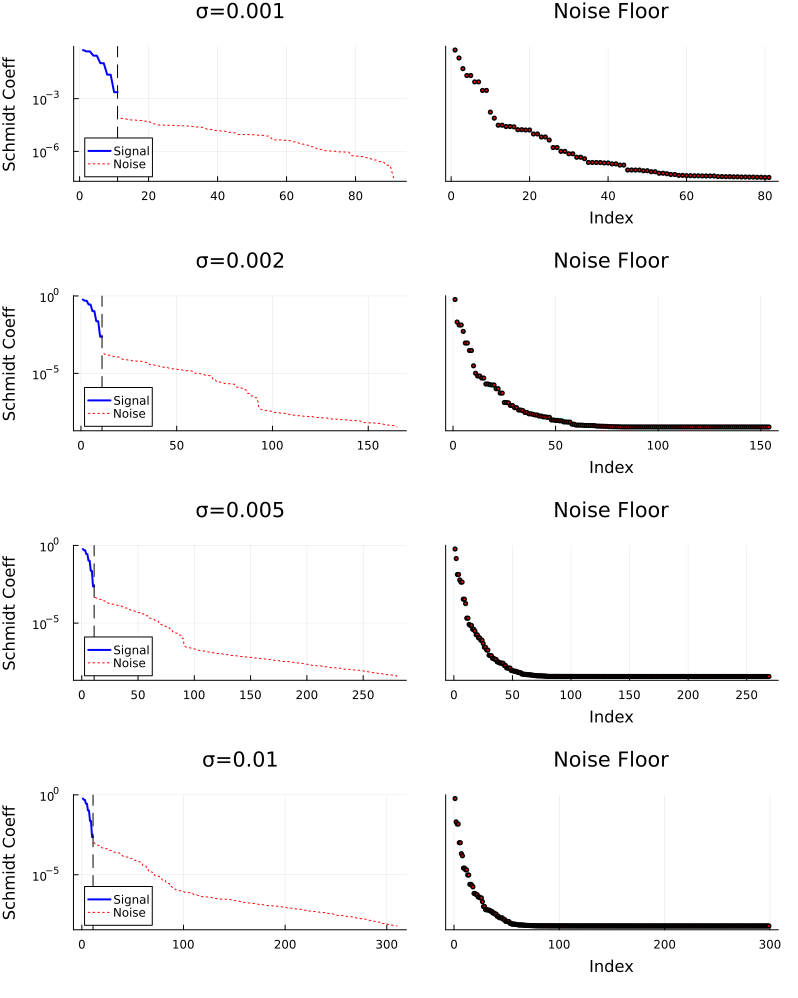

(OrderedDict{Any, Any}(0.001 => Dict{String, Any}("kept_tail" => [0.586267107406803, 0.4885608184510245, 0.48856081845102245, 0.2791860011681863, 0.2791860011681844, 0.10469999226206479, 0.10469999226206389, 0.023268294655629698, 0.023268294655629445, 0.0023270388141287414, 0.0023270388141287263], "w_kept" => 0.9999999484257717, "w_cut" => 5.157422971215364e-8, "bond_dim_reduction" => 81, "cut_tail" => [7.64942458242026e-5, 7.172030358430397e-5, 6.53222712743801e-5, 6.119723785344257e-5, 6.11972378534323e-5, 5.737658221969801e-5, 5.7376582219688e-5, 5.225849184365394e-5, 5.2258491843638334e-5, 3.924267711057242e-5  …  4.3455241473723355e-7, 4.345524147363993e-7, 3.211614818013711e-7, 3.211614818004983e-7, 2.606068695966422e-7, 2.606068695965728e-7, 1.6142600892560484e-7, 1.6142600892512423e-7, 3.2575908470928716e-8, 3.257590847078331e-8]), 0.002 => Dict{String, Any}("kept_tail" => [0.5862759329959943, 0.4885625443288113, 0.4885625443288091, 0.27917733887242013, 0.27917733887241575, 0.1

In [55]:
"""
analyze_tail_cuts(N, σ_vals, data_loc)

1. Sorts σ_vals to ensure plots are ordered (Low Noise -> High Noise).
2. Finds 'Ideal Cutoff' index from σ=0.0.
3. Slices noisy spectra and plots 'Kept' vs 'Cut' tails.
4. Returns an OrderedDict of separated tails.
"""
function analyze_tail_cuts(N, σ_vals, data_loc; threshold=1e-15)
    # Sort sigmas to guarantee processing order
    sort!(σ_vals)
    results = OrderedDict()
    
    if !isfile(data_loc)
        println("Error: File not found at $data_loc")
        return nothing, 0
    end

    # --- STEP 1: DETERMINE IDEAL CUTOFF FROM SIGMA = 0 ---
    ideal_cutoff_index = 0
    clean_coefs = Float64[]

    jldopen(data_loc, "r") do file
        group_key = "N=$(N)"
        if !haskey(file, group_key)
            println("Error: Group $group_key not found in JLD2 file.")
            return
        end
        
        # Robust search for 0.0
        keys_in_group = keys(file[group_key])
        zero_key = nothing
        for k in keys_in_group
            if startswith(k, "sigma=")
                val = parse(Float64, replace(k, "sigma=" => ""))
                if val == 0.0
                    zero_key = k
                    break
                end
            end
        end

        if isnothing(zero_key)
            println("Error: No baseline σ=0.0 found for N=$N.")
            return
        end

        # Load clean data
        raw = file[group_key][zero_key]["schmidt_coefs"][1]
        clean_coefs = raw isa Vector ? raw : raw.storage.data
        
        # Ensure Coefs are Descending
        sort!(clean_coefs, rev=true)

        # Define Cutoff: count coeffs above threshold
        ideal_cutoff_index = count(x -> x > threshold, clean_coefs)
    end
    
    println("\n=== N=$N Analysis ===")
    println("Ideal Bond Dimension (from σ=0): χ = $ideal_cutoff_index")

    # --- STEP 2: APPLY CUT TO NOISY DATA ---
    plot_list = []
    
    jldopen(data_loc, "r") do file
        group_key = "N=$(N)"
        
        for σ in σ_vals
            if σ == 0 continue end 
            
            # Find key corresponding to this sigma
            sigma_key = nothing
            for k in keys(file[group_key])
                if startswith(k, "sigma=")
                    val = parse(Float64, replace(k, "sigma=" => ""))
                    if isapprox(val, σ, atol=1e-20)
                        sigma_key = k
                        break
                    end
                end
            end
            
            if !isnothing(sigma_key)
                raw = file[group_key][sigma_key]["schmidt_coefs"][1]
                noisy_coefs = raw isa Vector ? raw : raw.storage.data
                
                # Ensure descending order
                sort!(noisy_coefs, rev=true)
                
                # SLICE THE TAIL
                # Cut at the ideal index derived from the clean case
                split_idx = min(length(noisy_coefs), ideal_cutoff_index)
                
                kept_tail = noisy_coefs[1:split_idx]
                cut_tail = (split_idx < length(noisy_coefs)) ? noisy_coefs[split_idx+1:end] : Float64[]
                
                w_kept = sum(kept_tail .^ 2)
                w_cut = sum(cut_tail .^ 2) 
                
                results[σ] = Dict(
                    "kept_tail" => kept_tail,
                    "cut_tail" => cut_tail,
                    "w_kept" => w_kept,
                    "w_cut" => w_cut,
                    "bond_dim_reduction" => length(noisy_coefs) - split_idx
                )
                
                # --- PLOTTING ---
                p1 = plot(
                    1:length(kept_tail), kept_tail, 
                    yscale=:log10, 
                    label="Signal", color=:blue, lw=2,
                    title="σ=$σ", ylabel="Schmidt Coeff", legend=:bottomleft
                )
                
                if !isempty(cut_tail)
                    x_cut = (split_idx+1):(split_idx+length(cut_tail))
                    plot!(p1, x_cut, cut_tail, label="Noise", color=:red, linestyle=:dot)
                    vline!(p1, [split_idx], color=:black, label="", linestyle=:dash)
                end

                p2 = plot(title="Noise Floor", xlabel="Index", yticks=:none)
                if !isempty(cut_tail)
                    plot!(p2, 1:length(cut_tail), cut_tail, 
                          seriestype=:scatter, markersize=2, color=:red, label="", legend=false)
                else
                    annotate!(p2, [(0.5, 0.5, ("No Cut", 8, :gray))])
                end
                
                combined = plot(p1, p2, layout=(1,2), size=(800, 250), margin=3Plots.mm)
                push!(plot_list, combined)
            end
        end
    end
    
    if !isempty(plot_list)
        total_h = 250 * length(plot_list)
        display(plot(plot_list..., layout=(length(plot_list), 1), size=(800, total_h)))
    end
    
    return results, ideal_cutoff_index
end

N_target = 20 

results, ideal_chi = analyze_tail_cuts(N_target, σ_vals, data_loc)

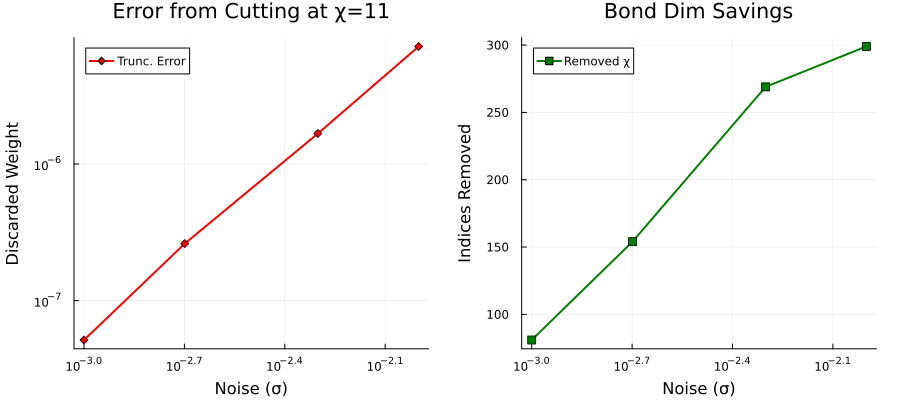

In [56]:
"""
plot_cut_weights(results_dict, ideal_chi)
Plots 'Truncation Error' vs Noise.
"""
function plot_cut_weights(results_dict, ideal_chi)
    sigmas = sort(collect(keys(results_dict)))
    
    cut_errors = [results_dict[s]["w_cut"] for s in sigmas]
    reductions = [results_dict[s]["bond_dim_reduction"] for s in sigmas]
    
    p1 = plot(
        sigmas, cut_errors,
        xscale=:log10, yscale=:log10,
        marker=:diamond, color=:red,
        title="Error from Cutting at χ=$(ideal_chi)",
        xlabel="Noise (σ)", ylabel="Discarded Weight",
        label="Trunc. Error", lw=2, legend=:topleft
    )
    
    p2 = plot(
        sigmas, reductions,
        xscale=:log10,
        marker=:square, color=:green,
        title="Bond Dim Savings",
        xlabel="Noise (σ)", ylabel="Indices Removed",
        label="Removed χ", lw=2, legend=:topleft
    )
    
    display(plot(p1, p2, layout=(1,2), size=(900, 400), margin=4Plots.mm))
end

plot_cut_weights(results, ideal_chi)

In [57]:
"""
predict_cutoff_strategy(results_dict)
Checks if Cut Weight scales with Sigma^2.
"""
function predict_cutoff_strategy(results_dict)
    println("\n--- CUTOFF STRATEGY CHECK ---")
    println(@sprintf("%-12s | %-15s | %-15s | %-10s", "Sigma", "Discarded W", "Expected (σ²)", "Ratio"))
    println("-"^65)
    
    for s in sort(collect(keys(results_dict)))
        w_cut = results_dict[s]["w_cut"]
        expected = s^2
        ratio = w_cut / expected
        println(@sprintf("%-12.1e | %-15.1e | %-15.1e | %-10.2f", s, w_cut, expected, ratio))
    end
end

predict_cutoff_strategy(results)


--- CUTOFF STRATEGY CHECK ---
Sigma        | Discarded W     | Expected (σ²)   | Ratio     
-----------------------------------------------------------------
1.0e-03      | 5.2e-08         | 1.0e-06         | 0.05      
2.0e-03      | 2.6e-07         | 4.0e-06         | 0.07      
5.0e-03      | 1.7e-06         | 2.5e-05         | 0.07      
1.0e-02      | 7.2e-06         | 1.0e-04         | 0.07      


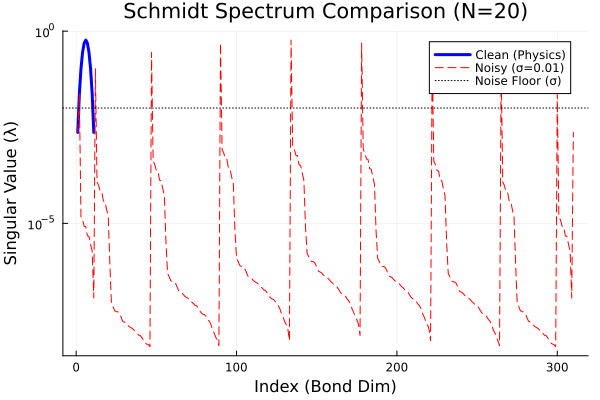

┌ Warning: type NDTensors.Dense{Float64,Vector{Float64}} does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\Ethan\.julia\packages\JLD2\hbsZG\src\data\reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Tensor{Float64,1,JLD2.ReconstructedMutable{Symbol("Dense{Float64,Vector{Float64}}"), (:data,), Tuple{Any}},Tuple{Int64}} does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\Ethan\.julia\packages\JLD2\hbsZG\src\data\reconstructing_datatypes.jl:588


Interpretation: If the Red dashed line follows the Blue line and then flattens at the Black dot line, the 'Spike' is purely numerical noise.


In [58]:

"""
compare_spectra(N, sigma, data_file)

Plots the Schmidt Spectrum of the Clean vs Noisy system.
If 'Real Physics' caused the spike, the ENTIRE curve would shift.
If it is an 'Artifact', the curves will overlap perfectly until the noise floor.
"""
function compare_spectra(N, sigma, data_loc)
    jldopen(data_loc, "r") do file
        # Fetch Data
        clean_path = "N=$(N)/sigma=0.0"
        noisy_path = "N=$(N)/sigma=$(sigma)"
        
        if !haskey(file, clean_path) || !haskey(file, noisy_path)
            println("Data missing for N=$N, sigma=$sigma")
            return
        end

        # Extract coefficients (handle vector wrapper if necessary)
        S_clean = file[clean_path]["schmidt_coefs"][1]
        S_noisy = file[noisy_path]["schmidt_coefs"][1]
        
        if typeof(S_clean) != Vector{Float64} S_clean = S_clean.storage.data end
        if typeof(S_noisy) != Vector{Float64} S_noisy = S_noisy.storage.data end

        # Plot
        p = plot(yaxis=:log10, title="Schmidt Spectrum Comparison (N=$N)", 
                 xlabel="Index (Bond Dim)", ylabel="Singular Value (λ)")
        
        plot!(p, S_clean, label="Clean (Physics)", linewidth=3, color=:blue)
        plot!(p, S_noisy, label="Noisy (σ=$sigma)", linestyle=:dash, color=:red)
        
        # Draw Noise Floor
        hline!(p, [sigma], label="Noise Floor (σ)", color=:black, linestyle=:dot)
        
        display(p)
        println("Interpretation: If the Red dashed line follows the Blue line and then flattens at the Black dot line, the 'Spike' is purely numerical noise.")
    end
end


compare_spectra(20, 0.01, data_loc)









In [60]:
using Printf

"""
predict_cutoff_strategy(results_dict)

Analyzes the truncation error to confirm the 'Spike' weight scales with sigma^2 (White Noise).
"""
function predict_cutoff_strategy(results_dict)
    println("\n--- Artifact Analysis ---")
    println("Testing if the discarded weight is dominated by noise (Error ≈ σ²)...")
    println("-"^65)
    println(@sprintf("%-12s | %-15s | %-15s | %-10s", "Sigma", "Discarded W", "Expected (σ²)", "Ratio"))
    println("-"^65)
    
    # 1. Get Sigmas from the keys and sort them
    sigmas = sort(collect(keys(results_dict)))
    
    for s in sigmas
        # 2. Access data directly using 's' as the key
        data = results_dict[s]
        
        # 3. Use the correct key name "w_cut" (from previous script), not "truncation_err"
        w_cut = data["w_cut"] 
        
        # 4. Calculate scaling
        expected = s^2 
        ratio = w_cut / expected
        
        if s > 0
            println(@sprintf("%-12.1e | %-15.1e | %-15.1e | %-10.2f", s, w_cut, expected, ratio))
        end
    end
    println("-"^65)
    println("VERDICT:")
    println("If 'Ratio' is roughly constant (approx 1.0 - 10.0), the extra bond dimension is purely noise.")
end

# Usage:
predict_cutoff_strategy(results)


--- Artifact Analysis ---
Testing if the discarded weight is dominated by noise (Error ≈ σ²)...
-----------------------------------------------------------------
Sigma        | Discarded W     | Expected (σ²)   | Ratio     
-----------------------------------------------------------------
1.0e-03      | 5.2e-08         | 1.0e-06         | 0.05      
2.0e-03      | 2.6e-07         | 4.0e-06         | 0.07      
5.0e-03      | 1.7e-06         | 2.5e-05         | 0.07      
1.0e-02      | 7.2e-06         | 1.0e-04         | 0.07      
-----------------------------------------------------------------
VERDICT:
If 'Ratio' is roughly constant (approx 1.0 - 10.0), the extra bond dimension is purely noise.
